<a href="https://colab.research.google.com/github/atalaydenknalbant/sentiment_analysis_roberta/blob/main/sentiment_analysis_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning RoBERTa on IMDb and Cross-Dataset Sentiment Analysis Evaluation

## Import And Load Dataset

We need to import libraries necessary for this task.

In [ ]:
!pip install -U accelerate
!pip install -U transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer, RobertaTokenizer, RobertaForSequenceClassification
!pip install datasets
from datasets import load_dataset, Dataset,DatasetDict, load_metric
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
!pip install deep_translator
from deep_translator import GoogleTranslator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Load IMDB dataset for training model.

In [ ]:
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

dataset = load_dataset("imdb")
print(dataset['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Data Preprocessing

We need to tokenize dataset first

<b>Why Tokenization:</b>
Tokenization of large text datasets reduces them into small, manageable text pieces. For example, words or subwords are very easy to analyze and process.

A more effective model training method can help the model learn from individual tokens and thus understand and generate every form of human language with context and meaning. Tokenization makes the input data standard, and this is a key element in helping the models process natural language perfectly and efficiently.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Prepare train test datasets

We will use predetermined imdb train and test datasets for this task. Both have 25k rows.

In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["test"]


## Train Model

We will use RoBERTa as our model since it provides better accuracy compared to other models. And we will use these metrics to correctly analyze it's performance:

* 1. Accuracy: It is the model's overall correctness that is measured as the number of true predictions the model makes about the target divided by everything the model predicts.

* 2. Precision: It is an ability to predict the true positive out of the general efficiency of examples that are predicted positive from the true positive and minimizing the false positives.

* 3. Recall: In essence, the model will recall positive cases, that is, it can identify the ratio of true positives to positive instances, hence making sure false negatives are minimal.

* 4. F1 Score: Taking into account recall and precision equally, it is a useful parameter for such cases in NLP tasks where classes are imbalanced, for the simple reason that it does not average precision against recall but instead combines both.

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir=output_dir,
    logging_steps=10,
    report_to="none",
    seed=42,
    lr_scheduler_type='linear',
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.329300,0.241990,0.935520,0.943467,0.926560,0.934937


TrainOutput(global_step=3125, training_loss=0.33780276640892026, metrics={'train_runtime': 3230.4623, 'train_samples_per_second': 7.739, 'train_steps_per_second': 0.967, 'total_flos': 6577776384000000.0, 'train_loss': 0.33780276640892026, 'epoch': 1.0})

## Evaluation

### IMDB

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It includes 25,000 highly polar movie reviews for training, and 25,000 for testing. 100,000 rows.

<b>Columns</b>
* label: sentiment int 32 feature
* text: text input string feature

In [ ]:
imdb_results = trainer.evaluate()
print("IMDB Evaluation Results:", imdb_results)

IMDB Evaluation Results: {'eval_loss': 0.24199025332927704, 'eval_accuracy': 0.93552, 'eval_precision': 0.9434669273378951, 'eval_recall': 0.92656, 'eval_f1': 0.9349370358411365, 'eval_runtime': 784.0728, 'eval_samples_per_second': 31.885, 'eval_steps_per_second': 3.986, 'epoch': 1.0}


Discussion

The model performs excellently on the IMDB dataset, indicating strong sentiment analysis capabilities for English movie reviews. This high accuracy reflects the model's effective training on English data.

### Sentiment140

Sentiment140 consists of 1.6 million Twitter messages with emoticons, which are used as noisy labels for sentiment classification.

<b>Columns</b>
* text: a string feature.
* date: a string feature.
* user: a string feature.
* sentiment: a int32 feature.
* query: a string feature.

In [ ]:
sentiment140_dataset = load_dataset("sentiment140")

def filter_and_rename_labels(batch):
    indices_to_keep = [i for i, sentiment in enumerate(batch["sentiment"]) if sentiment != 2]
    filtered_batch = {key: [value[i] for i in indices_to_keep] for key, value in batch.items()}
    filtered_batch["label"] = [0 if sentiment == 0 else 1 for sentiment in filtered_batch["sentiment"]]
    return filtered_batch

sentiment140_dataset = sentiment140_dataset.map(filter_and_rename_labels, batched=True, remove_columns=["sentiment"])

tokenized_sentiment140 = sentiment140_dataset.map(tokenize_function, batched=True)

test_dataset_sentiment140 = tokenized_sentiment140["test"]

sentiment140_results = trainer.evaluate(eval_dataset=test_dataset_sentiment140)
print("Sentiment140 Evaluation Results:", sentiment140_results)

sentiment140_predictions = trainer.predict(test_dataset_sentiment140)
metrics = compute_metrics((sentiment140_predictions.predictions, sentiment140_predictions.label_ids))
print("Sentiment140 Accuracy:", metrics['accuracy'])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sentiment140
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Sentiment140 Evaluation Results: {'eval_loss': 0.47093817591667175, 'eval_accuracy': 0.8467966573816156, 'eval_precision': 0.9044585987261147, 'eval_recall': 0.7802197802197802, 'eval_f1': 0.8377581120943952, 'eval_runtime': 10.7235, 'eval_samples_per_second': 33.478, 'eval_steps_per_second': 4.196, 'epoch': 1.0}
Sentiment140 Accuracy: 0.8467966573816156


Discussion

The lower accuracy on Sentiment140, which contains tweets, suggests challenges in handling informal language, slang, and tweet-specific nuances. This indicates room for improvement in understanding social media text.

### Turkish Product Comments

Turkish Product Reviews 342.367 rows.

<b>Columns</b>
* output: a string feature for sentiment(Olumlu, Olumsuz, Notr).
* input: a string feature for text.
* instruction: a string feature.

In [ ]:
turkish_dataset = load_dataset("Marmara-NLP/CSE4078S24_Grp5_CombinedDataset_TurkishSentiment_Analysis")


def translate_to_english(text):
    try:
        translated_text = GoogleTranslator(source='tr', target='en').translate(text)
        return translated_text
    except Exception as e:
        print(f"Error translating text: {e}")
        return text

def translate_batch(batch):
    return {'text': [translate_to_english(text) for text in batch['input']]}


selected_turkish_dataset = turkish_dataset['train'].shuffle(seed=42).select(range(360))


selected_turkish_dataset = selected_turkish_dataset.map(translate_batch, batched=True)


def map_labels(batch):
    indices_to_keep = [i for i, sentiment in enumerate(batch["output"]) if sentiment != "Notr"]
    filtered_batch = {key: [value[i] for i in indices_to_keep] for key, value in batch.items()}
    filtered_batch["label"] = [1 if sentiment == "Olumlu" else 0 for sentiment in filtered_batch.pop("output")]
    return filtered_batch


selected_turkish_dataset = selected_turkish_dataset.map(map_labels, batched=True, remove_columns=["output"])


def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)


tokenized_selected_turkish_dataset = selected_turkish_dataset.map(tokenize_function, batched=True)


test_dataset_turkish = tokenized_selected_turkish_dataset


turkish_results = trainer.evaluate(eval_dataset=test_dataset_turkish)
print("Turkish Dataset Evaluation Results:", turkish_results)


turkish_predictions = trainer.predict(test_dataset_turkish)
metrics = compute_metrics((turkish_predictions.predictions, turkish_predictions.label_ids))



Generating train split:   0%|          | 0/342367 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/252 [00:00<?, ? examples/s]

Turkish Dataset Evaluation Results: {'eval_loss': 0.2938110828399658, 'eval_accuracy': 0.9087301587301587, 'eval_precision': 0.9906542056074766, 'eval_recall': 0.9098712446351931, 'eval_f1': 0.948545861297539, 'eval_runtime': 7.5712, 'eval_samples_per_second': 33.284, 'eval_steps_per_second': 4.227, 'epoch': 1.0}


Discussion

The model performs well on Turkish product reviews, demonstrating its multilingual capability. However, the slight drop compared to English data suggests the need for better handling of non-English languages.

## Results of Our RoBERTa Model Finetuned only IMDB Dataset

In [ ]:
turkish_score = turkish_results.get('accuracy', None)
print(turkish_results['eval_accuracy'])

0.9087301587301587


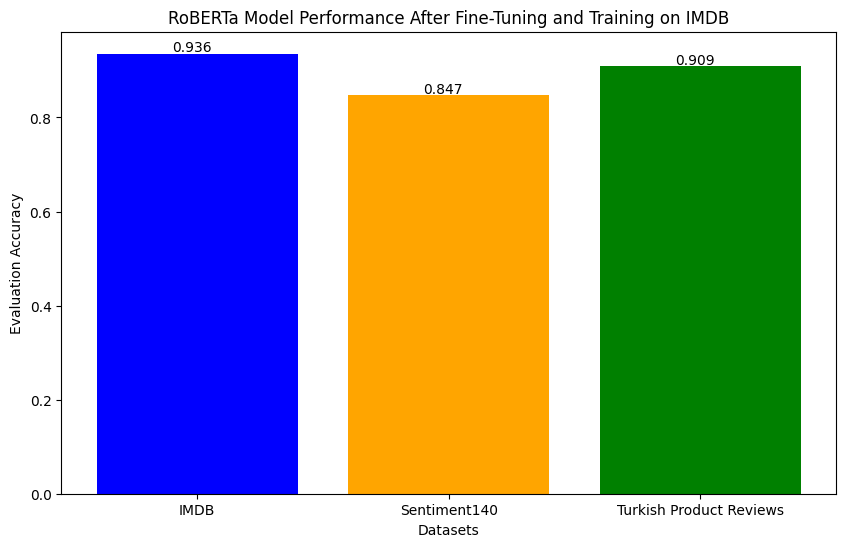

In [ ]:
import matplotlib.pyplot as plt

imdb_accuracy_score = imdb_results['eval_accuracy']
sentiment140_score = sentiment140_results['eval_accuracy']
turkish_score = turkish_results['eval_accuracy']
datasets = ['IMDB', 'Sentiment140', 'Turkish Product Reviews']
accuracies = [imdb_accuracy_score, sentiment140_score, turkish_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, accuracies, color=['blue', 'orange', 'green'])

plt.title('RoBERTa Model Performance After Fine-Tuning and Training on IMDB')
plt.xlabel('Datasets')
plt.ylabel('Evaluation Accuracy')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.005, round(yval, 3))

plt.show()

## Future Improvements
Enhanced Pre-Training:
Incorporating more diverse multilingual data during the pre-training phase can improve the model's performance across different languages and text styles.

Domain-Specific Fine-Tuning:
Fine-tuning on domain-specific datasets, such as tweets or product reviews in various languages, can help the model better understand the nuances specific to those domains.

Data Augmentation:
Using data augmentation techniques to create a more diverse training set can improve the model's robustness and generalization capabilities.